In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sqlalchemy import func

from quotes.models import ChadhNovel, BPOArticle, Alignment
from quotes.services import session

# Novel rankings, by raw alignment counts

In [2]:
count = func.count(Alignment.a_id)

alignment_counts = (
    session
    .query(ChadhNovel.slug, count)
    .join(Alignment)
    .filter(Alignment.size >= 5)
    .group_by(ChadhNovel.slug)
    .order_by(count.desc())
)

In [3]:
for slug, count in alignment_counts:
    print(slug, count)

Chadwyck_British_1863_Reade_HardCashA 6818
Chadwyck_British_1862_Collins_NoNameBy 6652
Chadwyck_British_1862_Braddon_LadyAudleySecret 5785
Chadwyck_British_1868_Collins_TheMoonstoneA 4485
Chadwyck_British_1859_Collins_TheWomanin 4443
Chadwyck_Irish_1864_Le Fanu_UncleSilasA 4173
Chadwyck_British_1850_Bell_TheLadderof 3893
Chadwyck_British_1839_Ainsworth_JackSheppardA 3769
Chadwyck_British_1861_Dickens_GreatExpectationsBy 3600
Chadwyck_British_1874_Hardy_Farfromthe 3358
Chadwyck_British_1838_Dickens_OliverTwistor 3233
Chadwyck_British_1883_Broughton_BelindaANovel 3177
Chadwyck_British_1861_Wood_EastLynneBy 3061
Chadwyck_British_1880_Trollope_TheDukeChildren 3032
Chadwyck_British_1878_Hardy_TheReturnof 2996
Chadwyck_British_1863_Eliot_RomolaByGeorge 2850
Chadwyck_British_1862_Thackeray_TheAdventuresof 2722
Chadwyck_British_1854_Dickens_HardTimesFor 2590
Chadwyck_British_1891_Hardy_Tessofthe 2513
Chadwyck_British_1866_Collins_ArmadaleByWilkie 2490
Chadwyck_British_1819_Scott_IvanhoeARomanc

# Alignment size distribution

In [4]:
from collections import OrderedDict

size_counts = OrderedDict(
    session
    .query(Alignment.size, func.count(Alignment.a_id))
    .filter(Alignment.size >= 5)
    .group_by(Alignment.size)
    .order_by(Alignment.size.desc())
    .all()
)

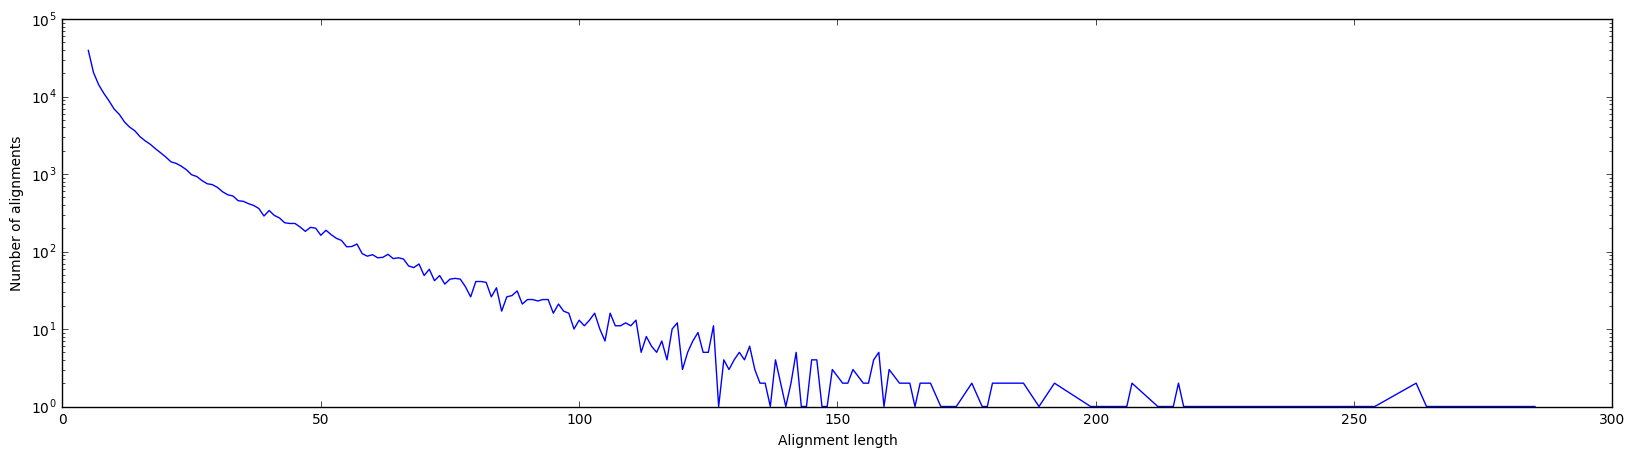

In [5]:
plt.figure(figsize=(20, 5))
plt.xlabel('Alignment length')
plt.ylabel('Number of alignments')
plt.yscale('log')

plt.plot(
    list(size_counts.keys()),
    list(size_counts.values()),
)

plt.show()

# Total BPO article length by year

In [3]:
from joblib import Memory

from quotes.models import BPOArticle

mem = Memory('cache')

bpo_year_lens = mem.cache(BPOArticle.year_lengths)()

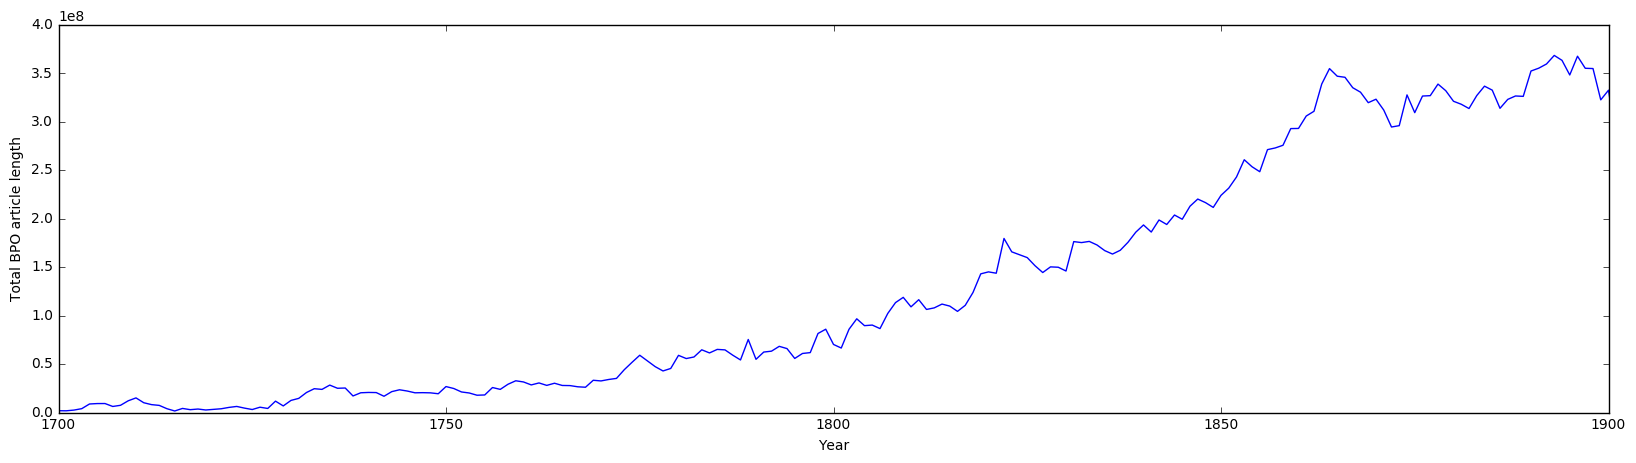

In [7]:
plt.figure(figsize=(20, 5))
plt.xlabel('Year')
plt.ylabel('Total BPO article length')
plt.xlim(1700, 1900)

plt.plot(
    list(bpo_year_lens.keys()),
    list(bpo_year_lens.values()),
)

plt.show()

# Adjusted novel rankings

- for each novel, get total BPO article length in decade after pub
- get total (5+) alignment size
- divide total size by BPO article length
- sort on this

In [8]:
data = []
for novel in ChadhNovel.query.all():

    bpo_len = 0
    for year in range(novel.year, novel.year+11):
        bpo_len += bpo_year_lens[year]
        
    alignment_len = (
        session
        .query(func.sum(Alignment.size))
        .filter(Alignment.a_id==novel.id, Alignment.size >= 5)
        .scalar()
    )
       
    alignment_count = (
        session
        .query(func.count(Alignment.a_id))
        .filter(Alignment.a_id==novel.id, Alignment.size >= 5)
        .scalar()
    )
    
    if alignment_len:
        
        score = alignment_len / bpo_len
        
        data.append((
            novel.slug,
            alignment_count,
            alignment_len,
            bpo_len,
            score,
        ))

In [9]:
import pandas as pd

df = pd.DataFrame(data, columns=(
    'slug',
    'alignment_count',
    'alignment_len',
    'bpo_len',
    'score',
))

df.sort_values('score', ascending=False, inplace=True)

In [10]:
pd.set_option('display.max_rows', 1000)

df.head(500)

,slug,alignment_count,alignment_len,bpo_len,score
148,Chadwyck_British_1863_Reade_HardCashA,6818,93222,3599400898,2.589931e-05
141,Chadwyck_British_1862_Collins_NoNameBy,6652,92686,3614247316,2.564462e-05
77,Chadwyck_British_1839_Ainsworth_JackSheppardA,3769,54390,2223732929,2.445887e-05
101,Chadwyck_British_1850_Bell_TheLadderof,3893,63796,2868597069,2.223944e-05
76,Chadwyck_British_1838_Dickens_OliverTwistor,3233,47663,2187740442,2.178641e-05
161,Chadwyck_British_1868_Collins_TheMoonstoneA,4485,65987,3506981943,1.881589e-05
197,Chadwyck_British_1884_Besant_DorothyForstera,1672,58047,3759691005,1.543930e-05
140,Chadwyck_British_1862_Braddon_LadyAudleySecret,5785,53060,3614247316,1.468079e-05
243,Chadwyck_Irish_1864_Le Fanu_UncleSilasA,4173,51637,3588140123,1.439102e-05
128,Chadwyck_British_1859_Collins_TheWomanin,4443,49569,3576295157,1.386043e-05
